<h2 align="center">Automatic Machine Learning with H2O AutoML</h2>

# Term Deposit Prediction - H2O AutoML

Here we need to find the best model which will be able to predict if the client of the bank opens the term deposit on the basis of his/her personal features, marketing history and current macroeconomic conditions.

In [2]:
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt

### Loading and Exploring the Data

In [3]:
#Get excel file with all spreadsheets
xls_file = pd.ExcelFile('data/bank_term_deposit_marketing_analysis.xlsx')

In [4]:
# show excel sheets
xls_file.sheet_names

['PROCEDURE',
 'DATA DESCRIPTION',
 'Step 1 - Collect Information',
 'CLIENT_INFO',
 'LOAN_HISTORY',
 'MARKETING HISTORY',
 'SUBSCRIPTION HISTORY',
 'Step 2 - Merge Information',
 'CLIENT_MERGE',
 'Step 3 - Marketing Analysis',
 'DAILY RANGE',
 'JOB ANALYSIS',
 'Sheet3']

In [7]:
# get needed sheets
client = pd.read_excel(xls_file, 'CLIENT_INFO')
loan = pd.read_excel(xls_file, 'LOAN_HISTORY')
marketing = pd.read_excel(xls_file, 'MARKETING HISTORY')
subscription = pd.read_excel(xls_file, 'SUBSCRIPTION HISTORY')

In [8]:
print(client.head())
print(loan.head())
print(marketing.head())
subscription.head()

     ID  AGE           JOB  MARITAL  EDUCATION
0  2836   58    management  married   tertiary
1  2837   44    technician   single  secondary
2  2838   33  entrepreneur  married  secondary
3  2839   47   blue-collar  married    unknown
4  2840   33       unknown   single    unknown
     ID DEFAULT  BALANCE HOUSING LOAN
0  2836      no     2143     yes   no
1  2837      no       29     yes   no
2  2838      no        2     yes  yes
3  2839      no     1506     yes   no
4  2840      no        1      no   no
     ID  CONTACT  DAY MONTH  DURATION  CAMPAIGN  PDAYS  PREVIOUS POUTCOME
0  2836  unknown    5   may       261         1     -1         0  unknown
1  2837  unknown    5   may       151         1     -1         0  unknown
2  2838  unknown    5   may        76         1     -1         0  unknown
3  2839  unknown    5   may        92         1     -1         0  unknown
4  2840  unknown    5   may       198         1     -1         0  unknown


,ID,TERM_DEPOSIT
0,2836,no
1,2837,no
2,2838,no
3,2839,no
4,2840,no


#### Term deposit = yes/no - Binary classification problem

In [10]:
# merging tables by ID
df = pd.merge(client, loan, on=['ID'])
df = pd.merge(df, marketing, on=['ID'])
df = pd.merge(df, subscription, on=['ID'])
df.head()

,ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,TERM_DEPOSIT
0,2836,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,2837,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,2838,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,2839,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,2840,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [11]:
#Drop ID column (unique feature - no predictive value)
df = df.drop(['ID'], axis=1)

### Data Prep & Start H2O

In [12]:
# H2O = distributed ML computing system
import h2o
from h2o.automl import H2OAutoML

h2o.init() # inicializing h2o cluster

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /home/rhyme/.local/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpi85k0jru
  JVM stdout: /tmp/tmpi85k0jru/h2o_rhyme_started_from_python.out
  JVM stderr: /tmp/tmpi85k0jru/h2o_rhyme_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,8 months and 12 days !!!
H2O_cluster_name:,H2O_from_python_rhyme_yljkog
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.920 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [13]:
# pandas df to H2O df
h2o_df = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [16]:
#checking basic statistics
h2o_df.describe()

Rows:45211
Cols:17




,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,TERM_DEPOSIT
type,int,enum,enum,enum,enum,int,enum,enum,enum,int,enum,int,int,int,int,enum,enum
mins,18.0,,,,,-8019.0,,,,1.0,,0.0,1.0,-1.0,0.0,,
mean,40.93621021432807,,,,,1362.2720576850802,,,,15.806418791886923,,258.16307978146915,2.7638406582468997,40.19782796222158,0.5803233726305561,,
maxs,95.0,,,,,102127.0,,,,31.0,,4918.0,63.0,871.0,275.0,,
sigma,10.618762040975398,,,,,3044.7658291685216,,,,8.32247615304459,,257.52781226517124,3.0980208832791805,100.12874599059822,2.303441044931215,,
zeros,0,,,,,3514,,,,0,,3,0,0,36954,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,1.0,-1.0,0.0,unknown,no
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5.0,may,151.0,1.0,-1.0,0.0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,1.0,-1.0,0.0,unknown,no


In [17]:
# h2o data split , 75%
train_set , test_set = h2o_df.split_frame(ratios=[.75])

x = train_set.columns
y = 'TERM_DEPOSIT' # label
x.remove(y) # isolating features

### Run H2O AutoML

In [18]:
# check dataset balance
df.TERM_DEPOSIT.value_counts()

no     39922
yes     5289
Name: TERM_DEPOSIT, dtype: int64

In [20]:
#CREATE AutoML
# Max_runtime = 10 min
# unbalanced classes - set balance_classes = True
# binary classification - logloss metric
aml = H2OAutoML(max_runtime_secs=600, balance_classes = True, stopping_metric='logloss', seed = 1)

In [21]:
# Training
%time aml.train(x=x, y=y, training_frame = train_set)

AutoML progress: |████████████████████████████████████████████████████████| 100%


### AutoML Leaderboard and Ensemble Exploration

In [22]:
# Get best model from leaderboard
# binary classification  - AUC-ROC curve metric
lb = aml.leaderboard
lb.head(rows=lb.nrows) #show all rows

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20210126_022459,0.934881,0.218827,0.625037,0.175826,0.255226,0.0651405
XGBoost_grid__1_AutoML_20210126_022459_model_2,0.933804,0.199141,0.623155,0.164283,0.250218,0.0626091
StackedEnsemble_AllModels_AutoML_20210126_022459,0.932658,0.212597,0.621021,0.185808,0.253606,0.0643161
XGBoost_grid__1_AutoML_20210126_022459_model_5,0.932616,0.201595,0.618346,0.184433,0.250506,0.0627533
GBM_grid__1_AutoML_20210126_022459_model_1,0.931271,0.201783,0.606101,0.174542,0.252045,0.0635268
GBM_grid__1_AutoML_20210126_022459_model_2,0.930545,0.209056,0.606073,0.174722,0.256892,0.0659935
XGBoost_grid__1_AutoML_20210126_022459_model_1,0.930467,0.203995,0.609669,0.170897,0.253241,0.0641308
XGBoost_3_AutoML_20210126_022459,0.929584,0.204581,0.608052,0.16576,0.252678,0.063846
GBM_2_AutoML_20210126_022459,0.929372,0.226181,0.599981,0.186448,0.267113,0.0713492
XGBoost_grid__1_AutoML_20210126_022459_model_4,0.928868,0.213177,0.601155,0.173472,0.258124,0.066628


In [25]:
best_model = aml.leader

# Get best model from stacked ensemble best model
metalearner = h2o.get_model(best_model.metalearner()['name'])
metalearner.varimp()

[('XGBoost_grid__1_AutoML_20210126_022459_model_2',
  0.6795529302985998,
  1.0,
  0.4511800561889672),
 ('GBM_grid__1_AutoML_20210126_022459_model_1',
  0.6036054573140505,
  0.8882390618915035,
  0.40075574985344403),
 ('DeepLearning_1_AutoML_20210126_022459',
  0.12214672543162862,
  0.1797457121963356,
  0.08109768052846862),
 ('XRT_1_AutoML_20210126_022459',
  0.0584615129531566,
  0.08602937364638874,
  0.038814737635679324),
 ('DRF_1_AutoML_20210126_022459',
  0.042401301810932525,
  0.062395878114014064,
  0.028151775793440813),
 ('GLM_1_AutoML_20210126_022459', 0.0, 0.0, 0.0)]

### Base Learner XGBoost Model Exploration

In [27]:
# exploring 'XGBoost_grid__1_AutoML_20210126_022459_model_2'
best_component = h2o.get_model('XGBoost_grid__1_AutoML_20210126_022459_model_2')

# Testing best component from stacked ensemble
best_component.model_performance(test_set)


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.06281436202930263
RMSE: 0.25062793545273965
LogLoss: 0.20037889034020762
Mean Per-Class Error: 0.1286041961074762
AUC: 0.9338653374621895
AUCPR: 0.6354794226299794
Gini: 0.8677306749243789

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21714135431326353: 


,,no,yes,Error,Rate
0,no,9132.0,942.0,0.0935,(942.0/10074.0)
1,yes,298.0,1057.0,0.2199,(298.0/1355.0)
2,Total,9430.0,1999.0,0.1085,(1240.0/11429.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.217141,0.630292,242.0
1,max f2,0.111049,0.741574,296.0
2,max f0point5,0.491881,0.618902,141.0
3,max accuracy,0.491881,0.909966,141.0
4,max precision,0.979258,1.000000,0.0
5,max recall,0.000877,1.000000,397.0
6,max specificity,0.979258,1.000000,0.0
7,max absolute_mcc,0.217141,0.584239,242.0
8,max min_per_class_accuracy,0.136342,0.864999,282.0
9,max mean_per_class_accuracy,0.111049,0.871396,296.0



Gains/Lift Table: Avg response rate: 11.86 %, avg score: 11.42 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010062,0.878939,7.041129,7.041129,0.834783,0.924792,0.834783,0.924792,0.070849,0.070849,604.112947,604.112947
1,,2,0.020037,0.810132,6.806940,6.924546,0.807018,0.843130,0.820961,0.884139,0.067897,0.138745,580.693986,592.454600
2,,3,0.030011,0.749260,5.031216,6.295276,0.596491,0.777588,0.746356,0.848726,0.050185,0.188930,403.121642,529.527611
3,,4,0.040073,0.687218,6.014298,6.224725,0.713043,0.716615,0.737991,0.815554,0.060517,0.249446,501.429809,522.472486
4,,5,0.050048,0.642855,5.253182,6.031096,0.622807,0.665008,0.715035,0.785550,0.052399,0.301845,425.318185,503.109566
5,,6,0.100009,0.432095,4.741741,5.386983,0.562172,0.529654,0.638670,0.657714,0.236900,0.538745,374.174136,438.698253
6,,7,0.150057,0.280524,3.435808,4.736212,0.407343,0.351982,0.561516,0.555744,0.171956,0.710701,243.580755,373.621163
7,,8,0.200017,0.168078,2.348713,4.139859,0.278459,0.219235,0.490814,0.471690,0.117343,0.828044,134.871301,313.985918
8,,9,0.300026,0.066386,1.136432,3.138717,0.134733,0.108960,0.372120,0.350780,0.113653,0.941697,13.643193,213.871676
9,,10,0.400035,0.030400,0.361592,2.444436,0.042870,0.044939,0.289808,0.274320,0.036162,0.977860,-63.840802,144.443557


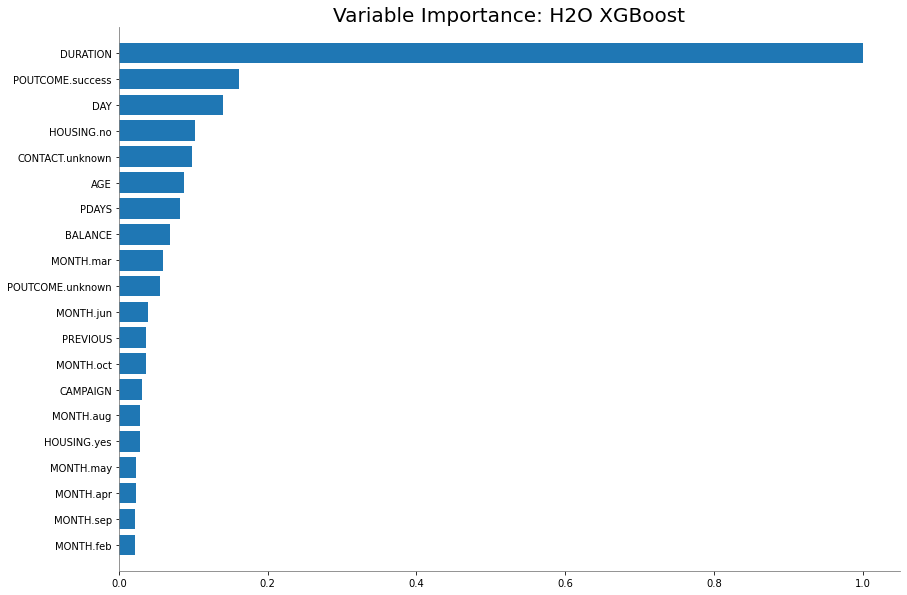

In [30]:
# checking most important features
best_component.varimp_plot(num_of_features=20)